In [1]:
import numpy as np
import pandas as pd
import tensorflow
import keras
import seaborn as sns
from collections import Counter
import nltk
import re
import codecs

C:\Users\Johnny\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
office = pd.read_csv("C:\\Users\\Johnny\\Documents\\UNH Notes and Documents 2018\\Spring 2018\\NLP and Time Series Analysis\\TheOfficeNLP\\TheOfficeNLP\\Data\\OfficeNLP_Final2.csv")

In [3]:
vals = ['jim', 'dwight']
chars = office['Name'].isin(vals)
office = office[chars]

In [4]:
#create dictionary to identify skin lesions
categorical_dict = {
    'jim': 1,
    'dwight': 2,
}

In [5]:
office['class_label'] = office['Name'].map(categorical_dict.get)

In [6]:
office.head()

,Unnamed: 0,Name,Line,class_label
1,1,jim,oh i told you i couldnt close it so,1
3,3,jim,actually you called me in here but yeah,1
16,16,dwight,singing shall i play for you pa rum pump um pu...,2
17,17,jim,my job is to speak to clients on the phone abo...,1
19,19,jim,whassup i still love that after seven years,1


In [7]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

office["tokens"] = office["Line"].apply(tokenizer.tokenize)
office.head()

,Unnamed: 0,Name,Line,class_label,tokens
1,1,jim,oh i told you i couldnt close it so,1,"[oh, i, told, you, i, couldnt, close, it, so]"
3,3,jim,actually you called me in here but yeah,1,"[actually, you, called, me, in, here, but, yeah]"
16,16,dwight,singing shall i play for you pa rum pump um pu...,2,"[singing, shall, i, play, for, you, pa, rum, p..."
17,17,jim,my job is to speak to clients on the phone abo...,1,"[my, job, is, to, speak, to, clients, on, the,..."
19,19,jim,whassup i still love that after seven years,1,"[whassup, i, still, love, that, after, seven, ..."


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in office["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in office["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

133246 words total, with a vocabulary size of 10247
Max sentence length is 154


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = office["Line"].tolist()
list_labels = office["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

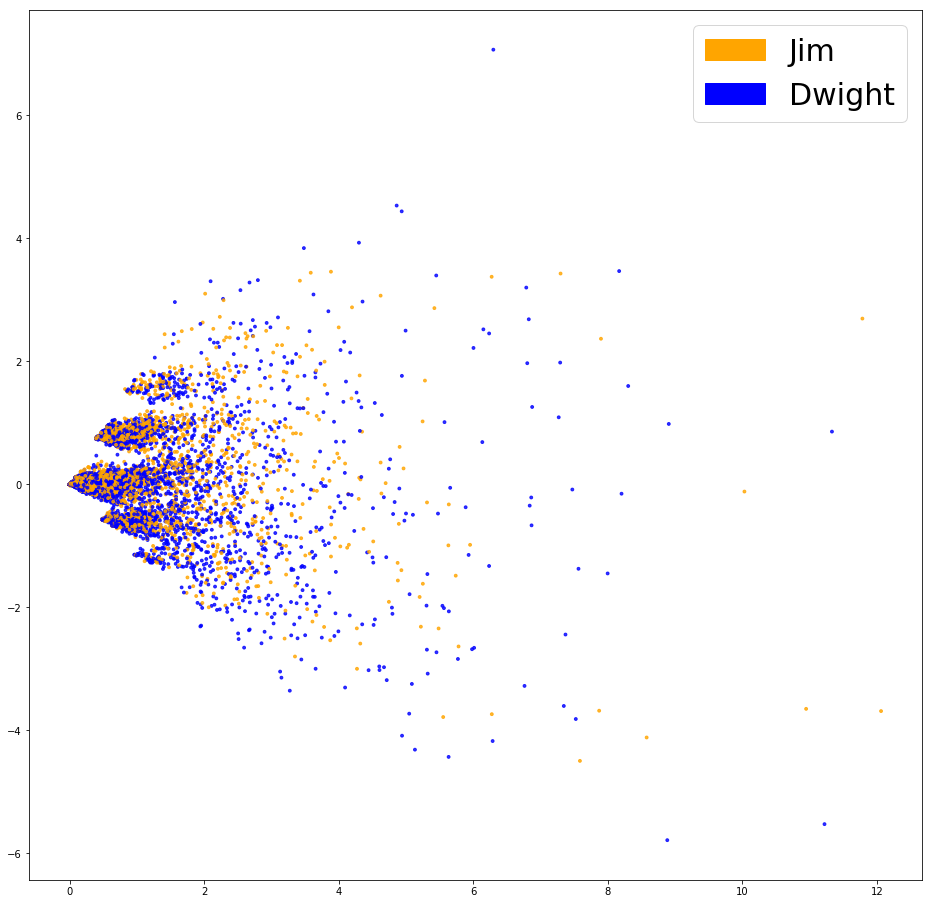

In [10]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Jim')
            green_patch = mpatches.Patch(color='blue', label='Dwight')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.633, precision = 0.637, recall = 0.633, f1 = 0.631


In [13]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

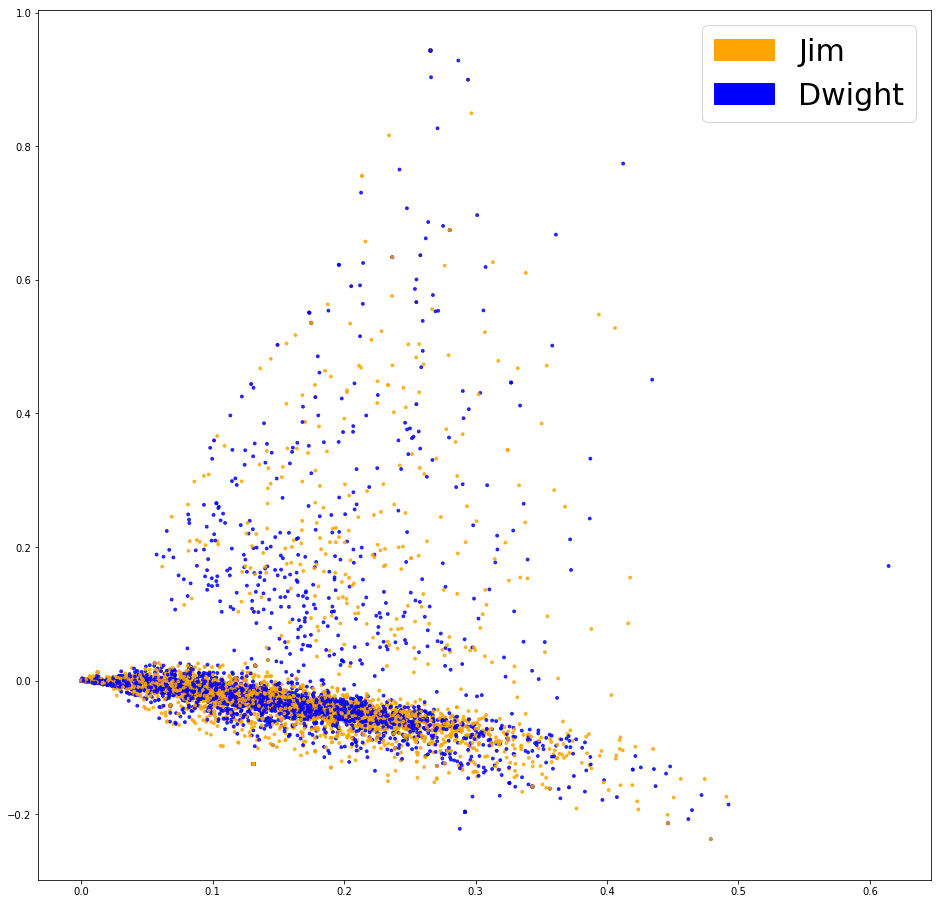

In [14]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [15]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [16]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.637, precision = 0.639, recall = 0.637, f1 = 0.637


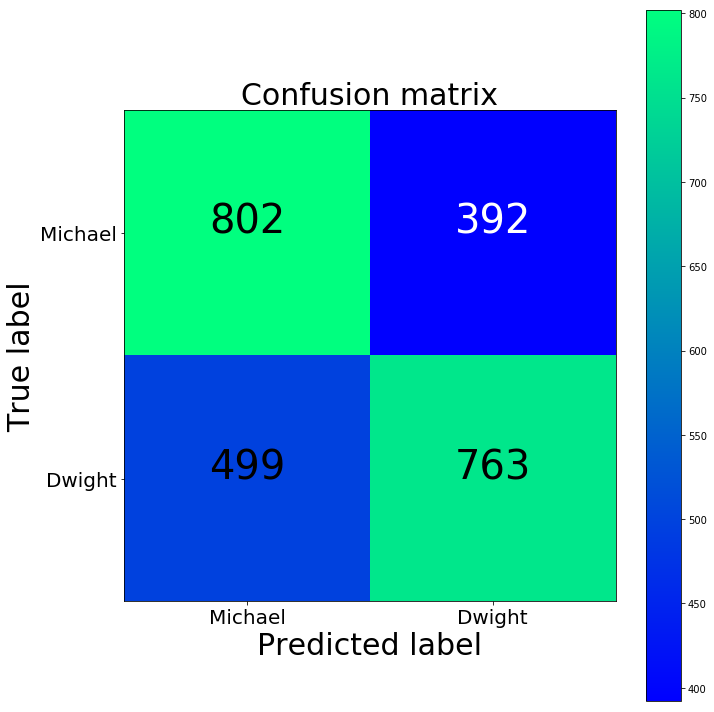

TFIDF confusion matrix
[[802 392]
 [499 763]]


In [17]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Michael','Dwight'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)

In [18]:
import gensim

word2vec_path = "C:\\Users\\Johnny\\Documents\\UNH Notes and Documents 2018\\Spring 2018\\NLP and Time Series Analysis\\TheOfficeNLP\\TheOfficeNLP\\Data\\GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [19]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = office['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [20]:
embeddings = get_word2vec_embeddings(word2vec, office)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

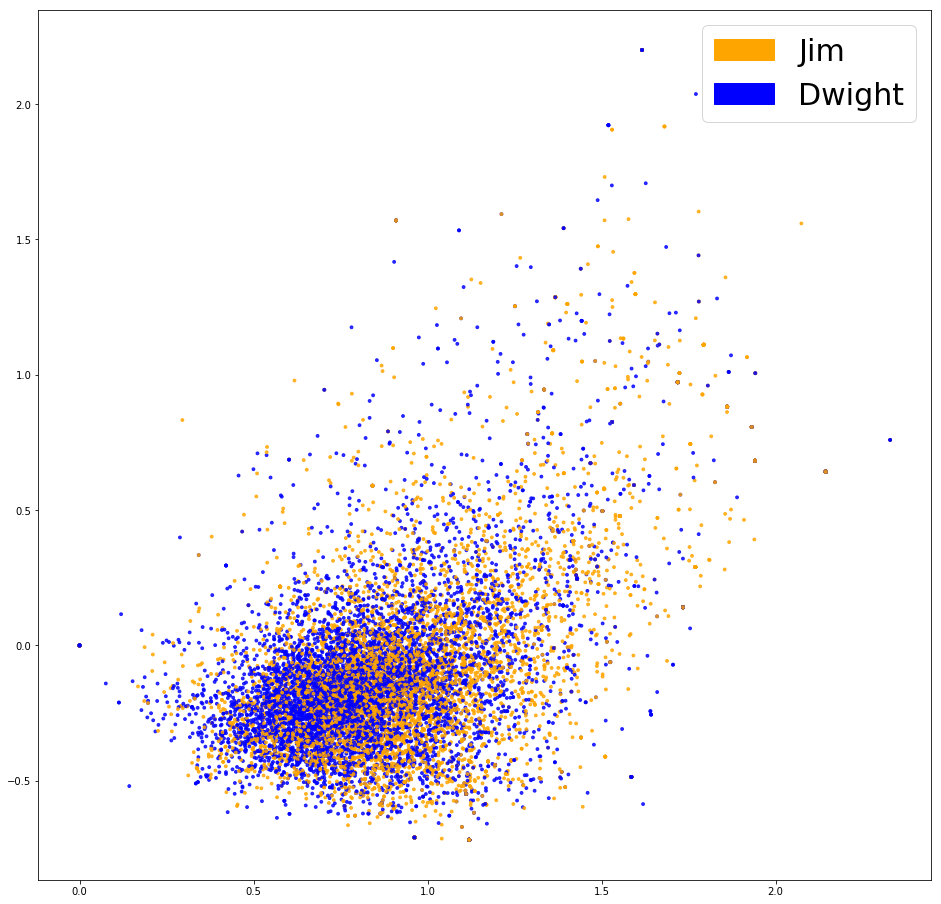

In [21]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [22]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [23]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.653, precision = 0.654, recall = 0.653, f1 = 0.653
